---
title: "Exploratory Data Analysis"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import plotly.colors as pc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import skew, kurtosis, yeojohnson, pearsonr


class EDA:
    def __init__(self, data):
        self.data = data

    # Basic statistics
    def describe_data(self):
        return self.data.describe()

    # Scatterplot with optional line of best fit
    def plot_scatter(self, col1, col2, add_line_of_best_fit=False, remove_outliers=False):
        # Ensure no missing data in both columns
        data_clean = self.data[[col1, col2]].dropna()

        if remove_outliers:
            # Calculate Q1 (25th percentile) and Q3 (75th percentile) for both columns
            Q1 = data_clean[[col1, col2]].quantile(0.25)
            Q3 = data_clean[[col1, col2]].quantile(0.75)
            IQR = Q3 - Q1
        
            # Remove outliers based on the IQR rule
            data_clean = data_clean[~((data_clean[col1] < (Q1[col1] - 1.5 * IQR[col1])) | 
                                    (data_clean[col1] > (Q3[col1] + 1.5 * IQR[col1])) |
                                    (data_clean[col2] < (Q1[col2] - 1.5 * IQR[col2])) | 
                                    (data_clean[col2] > (Q3[col2] + 1.5 * IQR[col2])))]
    
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=data_clean, x=col1, y=col2)
        plt.title(f'Scatterplot of {col1} vs {col2}')
        plt.xlabel(col1)
        plt.ylabel(col2)
    
        if add_line_of_best_fit:
            # Fit a linear regression model
            model = LinearRegression()
            X = data_clean[[col1]]  # Ensure there are no missing values
            y = data_clean[col2]
            model.fit(X, y)
            y_pred = model.predict(X)
            plt.plot(X, y_pred, color='red', label='Line of Best Fit')
            plt.legend()

        plt.show()
        
        #return plt
    
    def plot_correlation_heatmap(self):
        # Select numeric columns
        numeric_data = self.data.select_dtypes(include=np.number)
        
        # Compute the correlation matrix
        corr_matrix = numeric_data.corr()

        # Plot the heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Heatmap of Numeric Columns')
        plt.show()
        # return plt
    
    def voronoi_pie_slider(self, year_col, category_cols, output_html_path="../../assets/voronoi.html"):
        # Prepare data for the pie chart
        years = sorted(self.data[year_col].unique())

        # Define a color map for the categories using Plotly's qualitative color scale
        color_scale = pc.qualitative.Set3  # You can choose other color scales such as 'Set2', 'Set3', etc.
        
        # Ensure there are enough colors for the number of categories
        if len(category_cols) > len(color_scale):
            raise ValueError("Not enough colors in the selected color scale for the number of categories.")
        
        # Map categories to colors from the color scale
        color_map = {category: color_scale[i] for i, category in enumerate(category_cols)}

        fig = go.Figure()

        # Iterate over each year and create a frame for animation
        for i, year in enumerate(years):
            year_data = self.data[self.data[year_col] == year]
            values = year_data[category_cols].sum(axis=0)

            # Set the color of the pie slices according to the category
            colors = [color_map[category] for category in category_cols]

            fig.add_trace(
                go.Pie(
                    labels=category_cols,
                    values=values,
                    name=str(year),
                    hoverinfo='label+percent',  # Hover shows the label and percentage
                    hole=0.3,  # Add a hole to make the pie chart look like a donut
                    visible=(year == 2023),  # Make 2023 visible by default
                    marker=dict(colors=colors)  # Apply the fixed color map
                )
            )

        fig.update_layout(
            title='Distribution of Food Waste by Categories',
            showlegend=True,
            height=600,
            width=800,
            margin=dict(t=50, b=100, l=50, r=50),  # Add margin at the bottom for the buttons
            updatemenus=[{
                'buttons': [
                    {
                        'args': [{'visible': [i == j for i in range(len(years))]}],
                        'label': str(year),
                        'method': 'update'
                    } for j, year in enumerate(years)
                ],
                'direction': 'left',
                'showactive': True,
                'type': 'buttons',
                'x': 0.5,  
                'xanchor': 'center', 
                'y': -0.2, 
                'yanchor': 'top',
                'font': {'size': 10},  # Smaller button text
                'pad': {'r': 10, 't': 10}
            }]
        )

        # Show the plot
        fig.show()
        fig.write_html(output_html_path)

    def analyze_missing_values(self):
        missing_data = self.data.isnull().sum()
        missing_percentage = (missing_data / len(self.data)) * 100
        
        # Create a DataFrame to display missing data info
        missing_df = pd.DataFrame({
            'Missing Count': missing_data,
            'Missing Percentage': missing_percentage
        }).sort_values(by='Missing Count', ascending=False)
        
        print("Missing Values Analysis:")
        print(missing_df[missing_df['Missing Count'] > 0])
        #return missing_df
    
    def plot_distribution(self, col):
        plt.figure(figsize=(8, 6))
        sns.histplot(self.data[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
        #return plt
        
    # Boxplot for outlier detection
    def plot_boxplot(self, col):
        plt.figure(figsize=(8, 6))
        sns.boxplot(y=self.data[col])
        plt.title(f'Boxplot of {col}')
        plt.ylabel(col)
        plt.show()
        #return plt

    # Pairplot for relationships
    def plot_pairplot(self, cols=None):
        if cols is None:
            cols = self.data.select_dtypes(include=np.number).columns
        
        sns.pairplot(self.data[cols], diag_kind='kde')
        plt.suptitle('Pairplot of Selected Columns', y=1.02)
        plt.show()
        #return plt
    
    # Countplot for categorical data
    def plot_countplot(self, col):
        plt.figure(figsize=(8, 6))
        sns.countplot(data=self.data, x=col, order=self.data[col].value_counts().index)
        plt.title(f'Countplot of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()
        #return plt
    
    def plot_mean_nutrients_by_disposal(self, disposal_col, nutrient_cols):
        grouped_data = self.data.groupby(disposal_col)[nutrient_cols].mean()
        grouped_data.plot(kind='bar', figsize=(12, 8), colormap='viridis')
        plt.title(f'Mean Nutrient Content by {disposal_col}')
        plt.ylabel('Mean Nutrient Values')
        plt.xlabel(disposal_col)
        plt.xticks(rotation=45)
        plt.legend(title='Nutrient')
        plt.show()
        #return plt
    
    def plot_scatter_matrix(self, disposal_cols, nutrient_cols):
        selected_cols = disposal_cols + nutrient_cols
        sns.pairplot(self.data[selected_cols], diag_kind='kde')
        plt.suptitle('Scatterplot Matrix: Disposal Methods vs Nutrient Content', y=1.02)
        plt.show()
        #return plt
    
    def plot_disposal_nutrient_correlation(self, disposal_cols, nutrient_cols):
        selected_data = self.data[disposal_cols + nutrient_cols]
        corr_matrix = selected_data.corr()
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Heatmap: Disposal Methods vs Nutrient Content')
        plt.show()
        #return plt
    
    def plot_nutrient_boxplot_by_disposal(self, disposal_col, nutrient_col, bins=5):
        # Create bins for the disposal column
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=self.data, x=disposal_col, y=nutrient_col)
        plt.title(f'{nutrient_col} by {disposal_col}')
        plt.xlabel(disposal_col)
        plt.ylabel(nutrient_col)
        plt.xticks(rotation=45)
        plt.show()
        #return plt

    def plot_scatter_with_regression(self, disposal_col, nutrient_col):
        plt.figure(figsize=(10, 6))
        sns.regplot(data=self.data, x=disposal_col, y=nutrient_col, scatter_kws={'alpha': 0.7}, line_kws={'color': 'red'})
        plt.title(f'{nutrient_col} vs {disposal_col} with Regression Line')
        plt.xlabel(disposal_col)
        plt.ylabel(nutrient_col)
        plt.show()
        #return plt

    def plot_disposal_nutrient_pairplot(self, disposal_cols, nutrient_cols):
        subset = self.data[disposal_cols + nutrient_cols]
        sns.pairplot(subset, corner=True, diag_kind='kde', plot_kws={'alpha': 0.6})
        plt.suptitle('Pairplot of Disposal and Nutrient Features', y=1.02)
        plt.show()
        #return plt

    def plot_hexbin(self, disposal_col, nutrient_col, gridsize=30):
        plt.figure(figsize=(10, 6))
        plt.hexbin(self.data[disposal_col], self.data[nutrient_col], gridsize=gridsize, cmap='coolwarm', mincnt=1)
        plt.colorbar(label='Count')
        plt.title(f'Hexbin Plot of {nutrient_col} vs {disposal_col}')
        plt.xlabel(disposal_col)
        plt.ylabel(nutrient_col)
        plt.show()
        #return plt


    def plot_kde_2d(self, disposal_col, nutrient_col):
        plt.figure(figsize=(10, 6))
        sns.kdeplot(
            data=self.data, x=disposal_col, y=nutrient_col, cmap='coolwarm', fill=True, alpha=0.6
        )
        plt.title(f'2D KDE of {nutrient_col} vs {disposal_col}')
        plt.xlabel(disposal_col)
        plt.ylabel(nutrient_col)
        plt.show()
        #return plt

    def plot_jointplot(self, disposal_col, nutrient_col):
        sns.jointplot(
            data=self.data, x=disposal_col, y=nutrient_col, kind='reg', height=8, ratio=5, marginal_kws={'fill': True}
        )
        plt.suptitle(f'Jointplot of {nutrient_col} vs {disposal_col}', y=1.02)
        plt.show()
        #return plt

    def plot_disposal_nutrient_correlation(self, disposal_cols, nutrient_cols):
        correlation_data = self.data[disposal_cols + nutrient_cols].corr()
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Heatmap of Disposal and Nutrient Columns')
        plt.show()
    def plot_time_series(self):
        # Ensure that 'year' is in the data and is of numeric type
        if 'year' not in self.data.columns:
            raise ValueError("The dataset must contain a 'year' column.")

        # Group by year and calculate the sum of 'rescue', 'recycling', and 'foodwaste'
        time_series_data = self.data.groupby('year')[['rescue', 'recycling', 'foodwaste']].sum()

        # Create a Plotly figure
        fig = go.Figure()

        # Add traces for each variable (rescue, recycling, foodwaste)
        fig.add_trace(go.Scatter(x=time_series_data.index, y=time_series_data['rescue'], mode='lines+markers', name='Rescue (Donations)', line=dict(color='green')))
        fig.add_trace(go.Scatter(x=time_series_data.index, y=time_series_data['recycling'], mode='lines+markers', name='Recycling', line=dict(color='blue')))
        fig.add_trace(go.Scatter(x=time_series_data.index, y=time_series_data['foodwaste'], mode='lines+markers', name='Food Waste', line=dict(color='red')))

        # Update layout
        fig.update_layout(
            title='Rescue, Recycling, and Food Waste Over the Years',
            xaxis_title='Year',
            yaxis_title='Tons',
            template='plotly_dark', 
            legend_title='Disposal Method',
            showlegend=True
        )
        fig.write_html("../../assets/wastemethod.html")
        fig.show()
        #return fig
    
    def plot_us_dollars_surplus(self):
        # Ensure that 'year' and 'us_dollars_surplus' are in the data and are of numeric type
        if 'year' not in self.data.columns:
            raise ValueError("The dataset must contain a 'year' column.")
        if 'us_dollars_surplus' not in self.data.columns:
            raise ValueError("The dataset must contain a 'us_dollars_surplus' column.")

        # Group by year and calculate the sum of 'us_dollars_surplus'
        time_series_data = self.data.groupby('year')['us_dollars_surplus'].sum()

        # Create a Plotly figure
        fig = go.Figure()

        # Add trace for us_dollars_surplus
        fig.add_trace(go.Scatter(x=time_series_data.index, 
                                y=time_series_data, 
                                mode='lines+markers', 
                                name='US Dollars Surplus', 
                                line=dict(color='purple')))

        # Update layout
        fig.update_layout(
            title='Time Series of US Dollars Surplus From Wasted Food Over the Years',
            xaxis_title='Year',
            yaxis_title='US Dollars Surplus',
            template='plotly_dark',  # Optional: you can use different themes like plotly, plotly_dark, ggplot2, etc.
            showlegend=True
        )

        # Show the plot
        fig.show()
        fig.write_html("../../assets/dollarsurplus.html")
        #return fig
    
    def perform_clustering(self, n_clusters=3):
        """Apply K-Means clustering to numeric columns."""
        numeric_data = self.data.select_dtypes(include=['float64', 'int64'])

        # Drop rows with NaNs
        cleaned_data = numeric_data.dropna()

        # Perform K-Means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(cleaned_data)

        # Add cluster labels back to the cleaned data
        cleaned_data['Cluster'] = cluster_labels

        return cleaned_data

    def dimensionality_reduction(self, n_components=2):
        """Perform PCA for dimensionality reduction."""
        numeric_data = self.data.select_dtypes(include=['float64', 'int64'])
        cleaned_data = numeric_data.dropna()
        pca = PCA(n_components=n_components)
        self.pca_components = pca.fit_transform(cleaned_data)
        return pd.DataFrame(self.pca_components, columns=[f'PC{i+1}' for i in range(n_components)])
    
    def analyze_distribution(self):
        """Calculate and print skewness and kurtosis for all numeric columns."""
        results = {}
        for col in self.data.select_dtypes(include=['float64', 'int64']).columns:
            skewness = skew(self.data[col].dropna())
            kurt = kurtosis(self.data[col].dropna())
            results[col] = {'Skewness': skewness, 'Kurtosis': kurt}
        return pd.DataFrame(results).T

    def apply_transformations(self):
        """Apply transformations to skewed data."""
        self.transformed_data = self.data.copy()
        for col in self.data.select_dtypes(include=['float64', 'int64']).columns:
            skewness = skew(self.data[col].dropna())
            if abs(skewness) > 1:  # Consider skewness threshold
                self.transformed_data[col] = np.log1p(self.data[col])
        return self.transformed_data

    def normalize_data(self, method='z-score'):
        """Apply normalization techniques (z-score or min-max)."""
        self.normalized_data = self.data.copy()
        numeric_cols = self.data.select_dtypes(include=['float64', 'int64']).columns
        if method == 'z-score':
            scaler = StandardScaler()
        elif method == 'min-max':
            scaler = MinMaxScaler()
        else:
            raise ValueError("Method must be 'z-score' or 'min-max'.")
        self.normalized_data[numeric_cols] = scaler.fit_transform(self.data[numeric_cols])
        return self.normalized_data

    def feature_engineering(self):
        """Example feature engineering by categorizing food categories."""
        self.data['food_category_encoded'] = self.data['food_category'].astype('category').cat.codes
        return self.data

        



data = pd.read_csv('../../data/processed-data/food_merged.csv')
category_columns = [
    'tons_donations', 'tons_industrial_uses', 'tons_animal_feed',
    'tons_anaerobic_digestion', 'tons_composting', 'tons_not_harvested',
    'tons_incineration', 'tons_land_application', 'tons_landfill',
    'tons_sewer', 'tons_dumping'
]
data['total'] = data[category_columns].sum(axis=1)

# Calculate the percentage of total for each column
percentage_df = data[category_columns].div(data['total'], axis=0)

# Find the column with the maximum percentage for each row 
# to create a new column called disposal method 
# this indicates the primary disposal method
data['disposal_method'] = percentage_df.idxmax(axis=1)
data['disposal_method'] = data['disposal_method'].str.replace('tons_', '', regex=False)

# Drop the total column if no longer needed
data.drop(columns=['total'], inplace=True)

# Create new columns: rescue, recycling, and foodwaste
data['rescue'] = data['tons_donations']
data['recycling'] = data[['tons_industrial_uses', 'tons_animal_feed', 'tons_anaerobic_digestion', 'tons_composting']].sum(axis=1)
data['foodwaste'] = data[['tons_not_harvested', 'tons_incineration', 'tons_land_application', 'tons_landfill', 'tons_sewer', 'tons_dumping']].sum(axis=1)

# Create a donation binary column to indicate if donations exist
data['donation_bin'] = np.where(data['tons_donations'] > 0, 1, 0)
eda = EDA(data)


eda.analyze_missing_values()

Missing Values Analysis:
                     Missing Count  Missing Percentage
phosphorus                   14308           98.743961
potassium                    10710           73.913043
iron                          7952           54.879227
calcium                       7938           54.782609
fiber                         7770           53.623188
protein                       7462           51.497585
sodium                        7434           51.304348
calories                      7434           51.304348
carbs                         7434           51.304348
fat                           7434           51.304348
best_match                    7406           51.111111
score                         7406           51.111111
food_name                     7406           51.111111
serving_size                  7406           51.111111
percent_daily_value           7406           51.111111
disposal_method                266            1.835749


/var/folders/sj/4yswlk7n08x8jfcfnyw2vkqw0000gn/T/ipykernel_3697/1399258737.py:427: FutureWarning:

The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError



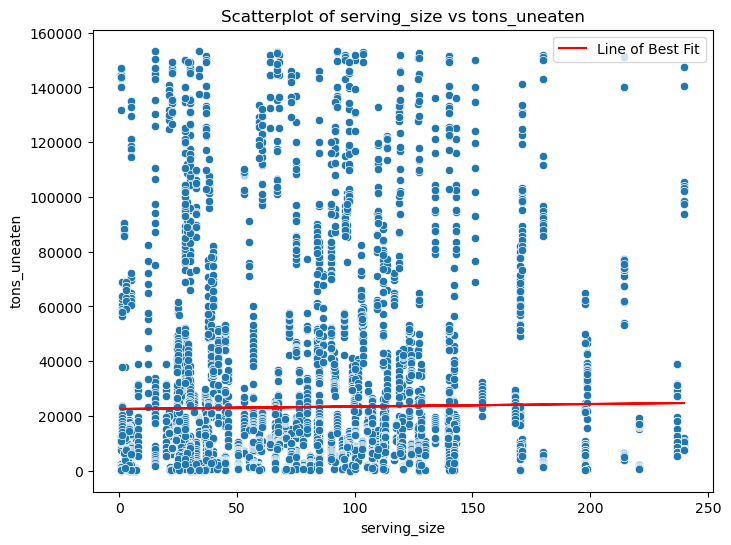

Correlation coefficient: 0.3415795157511618
P-value: 2.368552259759485e-06


In [ ]:


#2 trues at the end of this class method add a trend line and get rid of outliers
eda.plot_scatter('serving_size', 'tons_uneaten', True, True)

df_clean = data.replace([float('inf'), float('-inf')], float('nan')).dropna()

correlation, p_value = pearsonr(df_clean['serving_size'], df_clean['tons_uneaten'])

print(f"Correlation coefficient: {correlation}")
print(f"P-value: {p_value}")


The plot above, along with Pearson’s correlation coefficient of 0.34, indicates a positive correlation between the serving size of a food and the tons left uneaten. The associated p-value is so small that we can confidently reject the null hypothesis of no correlation.

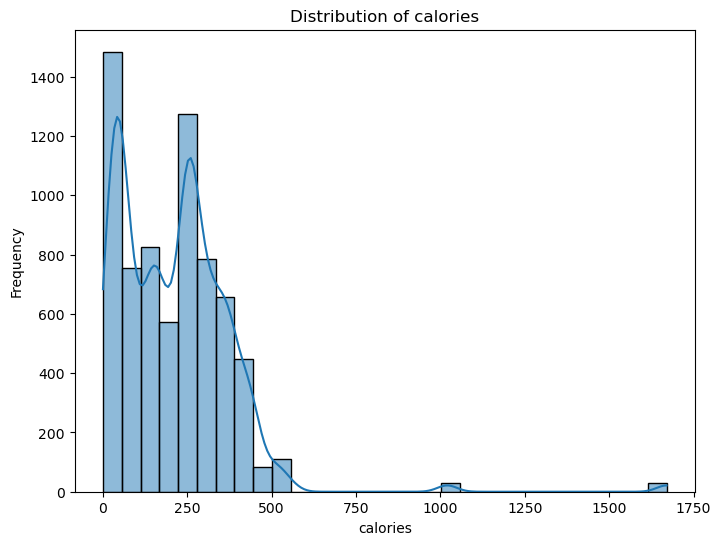

<module 'matplotlib.pyplot' from '/Users/shanaywadhwani/Desktop/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [69]:
eda.plot_distribution(col='calories')

The histogram of calories above demonstrates a bimodal distribution, with one peak in the range of 0-24 calories and another around 250 calories. The concentration of data in these two distinct ranges suggests that food items with low and moderate calorie content dominate the dataset. Additionally, the presence of outliers, particularly at higher calorie values, could be indicative of high-calorie, meal-prep food options. These items, likely designed for larger servings or specialized dietary needs, may contribute disproportionately to food waste, reflecting consumer preference patterns or over-purchasing behavior. This insight warrants further investigation into the relationship between food type, portion size, and waste generation.

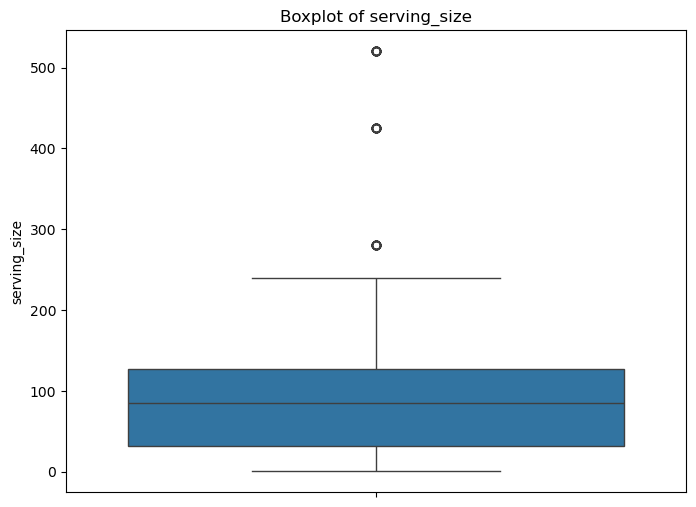

<module 'matplotlib.pyplot' from '/Users/shanaywadhwani/Desktop/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [70]:
eda.plot_boxplot(col='serving_size')

The boxplot of serving size reveals a median value of approximately 80 grams, indicating that the central tendency of serving sizes is relatively small. However, the plot also shows outliers beyond the 75th percentile, with some data points reaching up to 500 grams. These larger values likely correspond to meal kits or pre-packaged meals, which typically have larger portion sizes. The presence of these outliers suggests that a subset of food items, particularly those designed for meal preparation or larger servings, may contribute to higher levels of waste. This highlights the importance of considering portion size in waste reduction strategies, especially for meal kits and large-serving products.

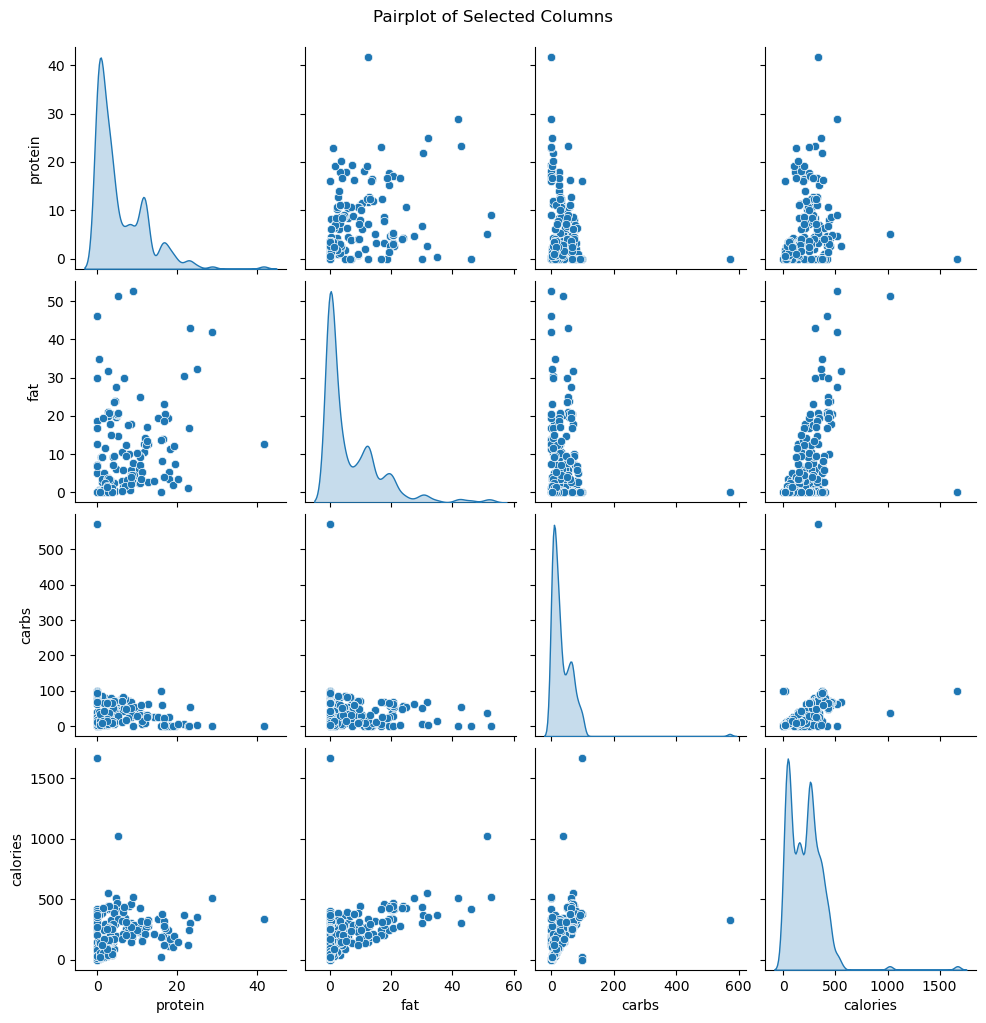

<module 'matplotlib.pyplot' from '/Users/shanaywadhwani/Desktop/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [71]:
eda.plot_pairplot(cols=['protein', 'fat', 'carbs', 'calories'])

The pair plot of macronutrients provides valuable insights into the relationships between various nutritional components. It reveals a clear positive correlation between calories and fats, suggesting that higher fat content in foods is generally associated with higher caloric values. Similarly, fats and carbohydrates are positively related, indicating that foods rich in fats tend to also contain higher amounts of carbohydrates. Additionally, the plot shows that foods with lower carbohydrate content often have higher protein levels, which may suggest a trend toward protein-dense, low-carb options. Lastly, there is a strong positive relationship between proteins and calories, further reinforcing that higher protein foods tend to be more calorie-dense. These patterns could guide nutrition-based interventions for reducing food waste, particularly for food categories with high fat, carbohydrate, and calorie content.

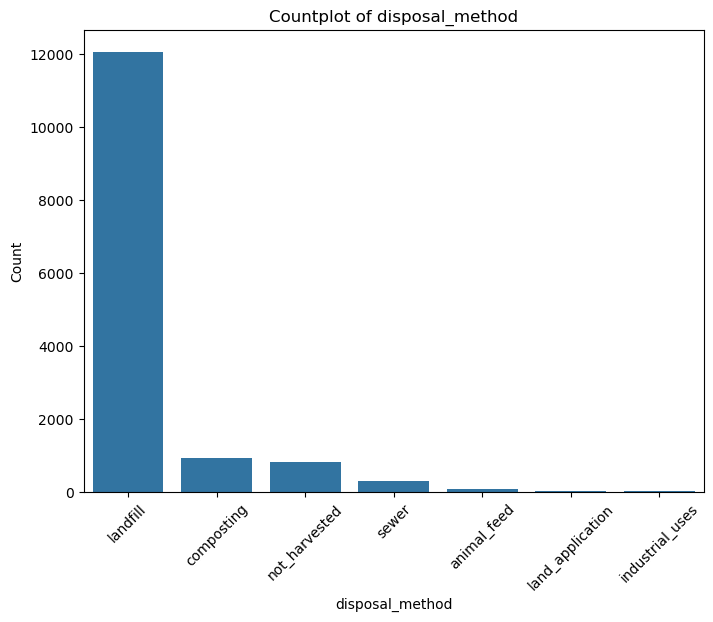

<module 'matplotlib.pyplot' from '/Users/shanaywadhwani/Desktop/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [72]:
eda.plot_countplot(col='disposal_method')

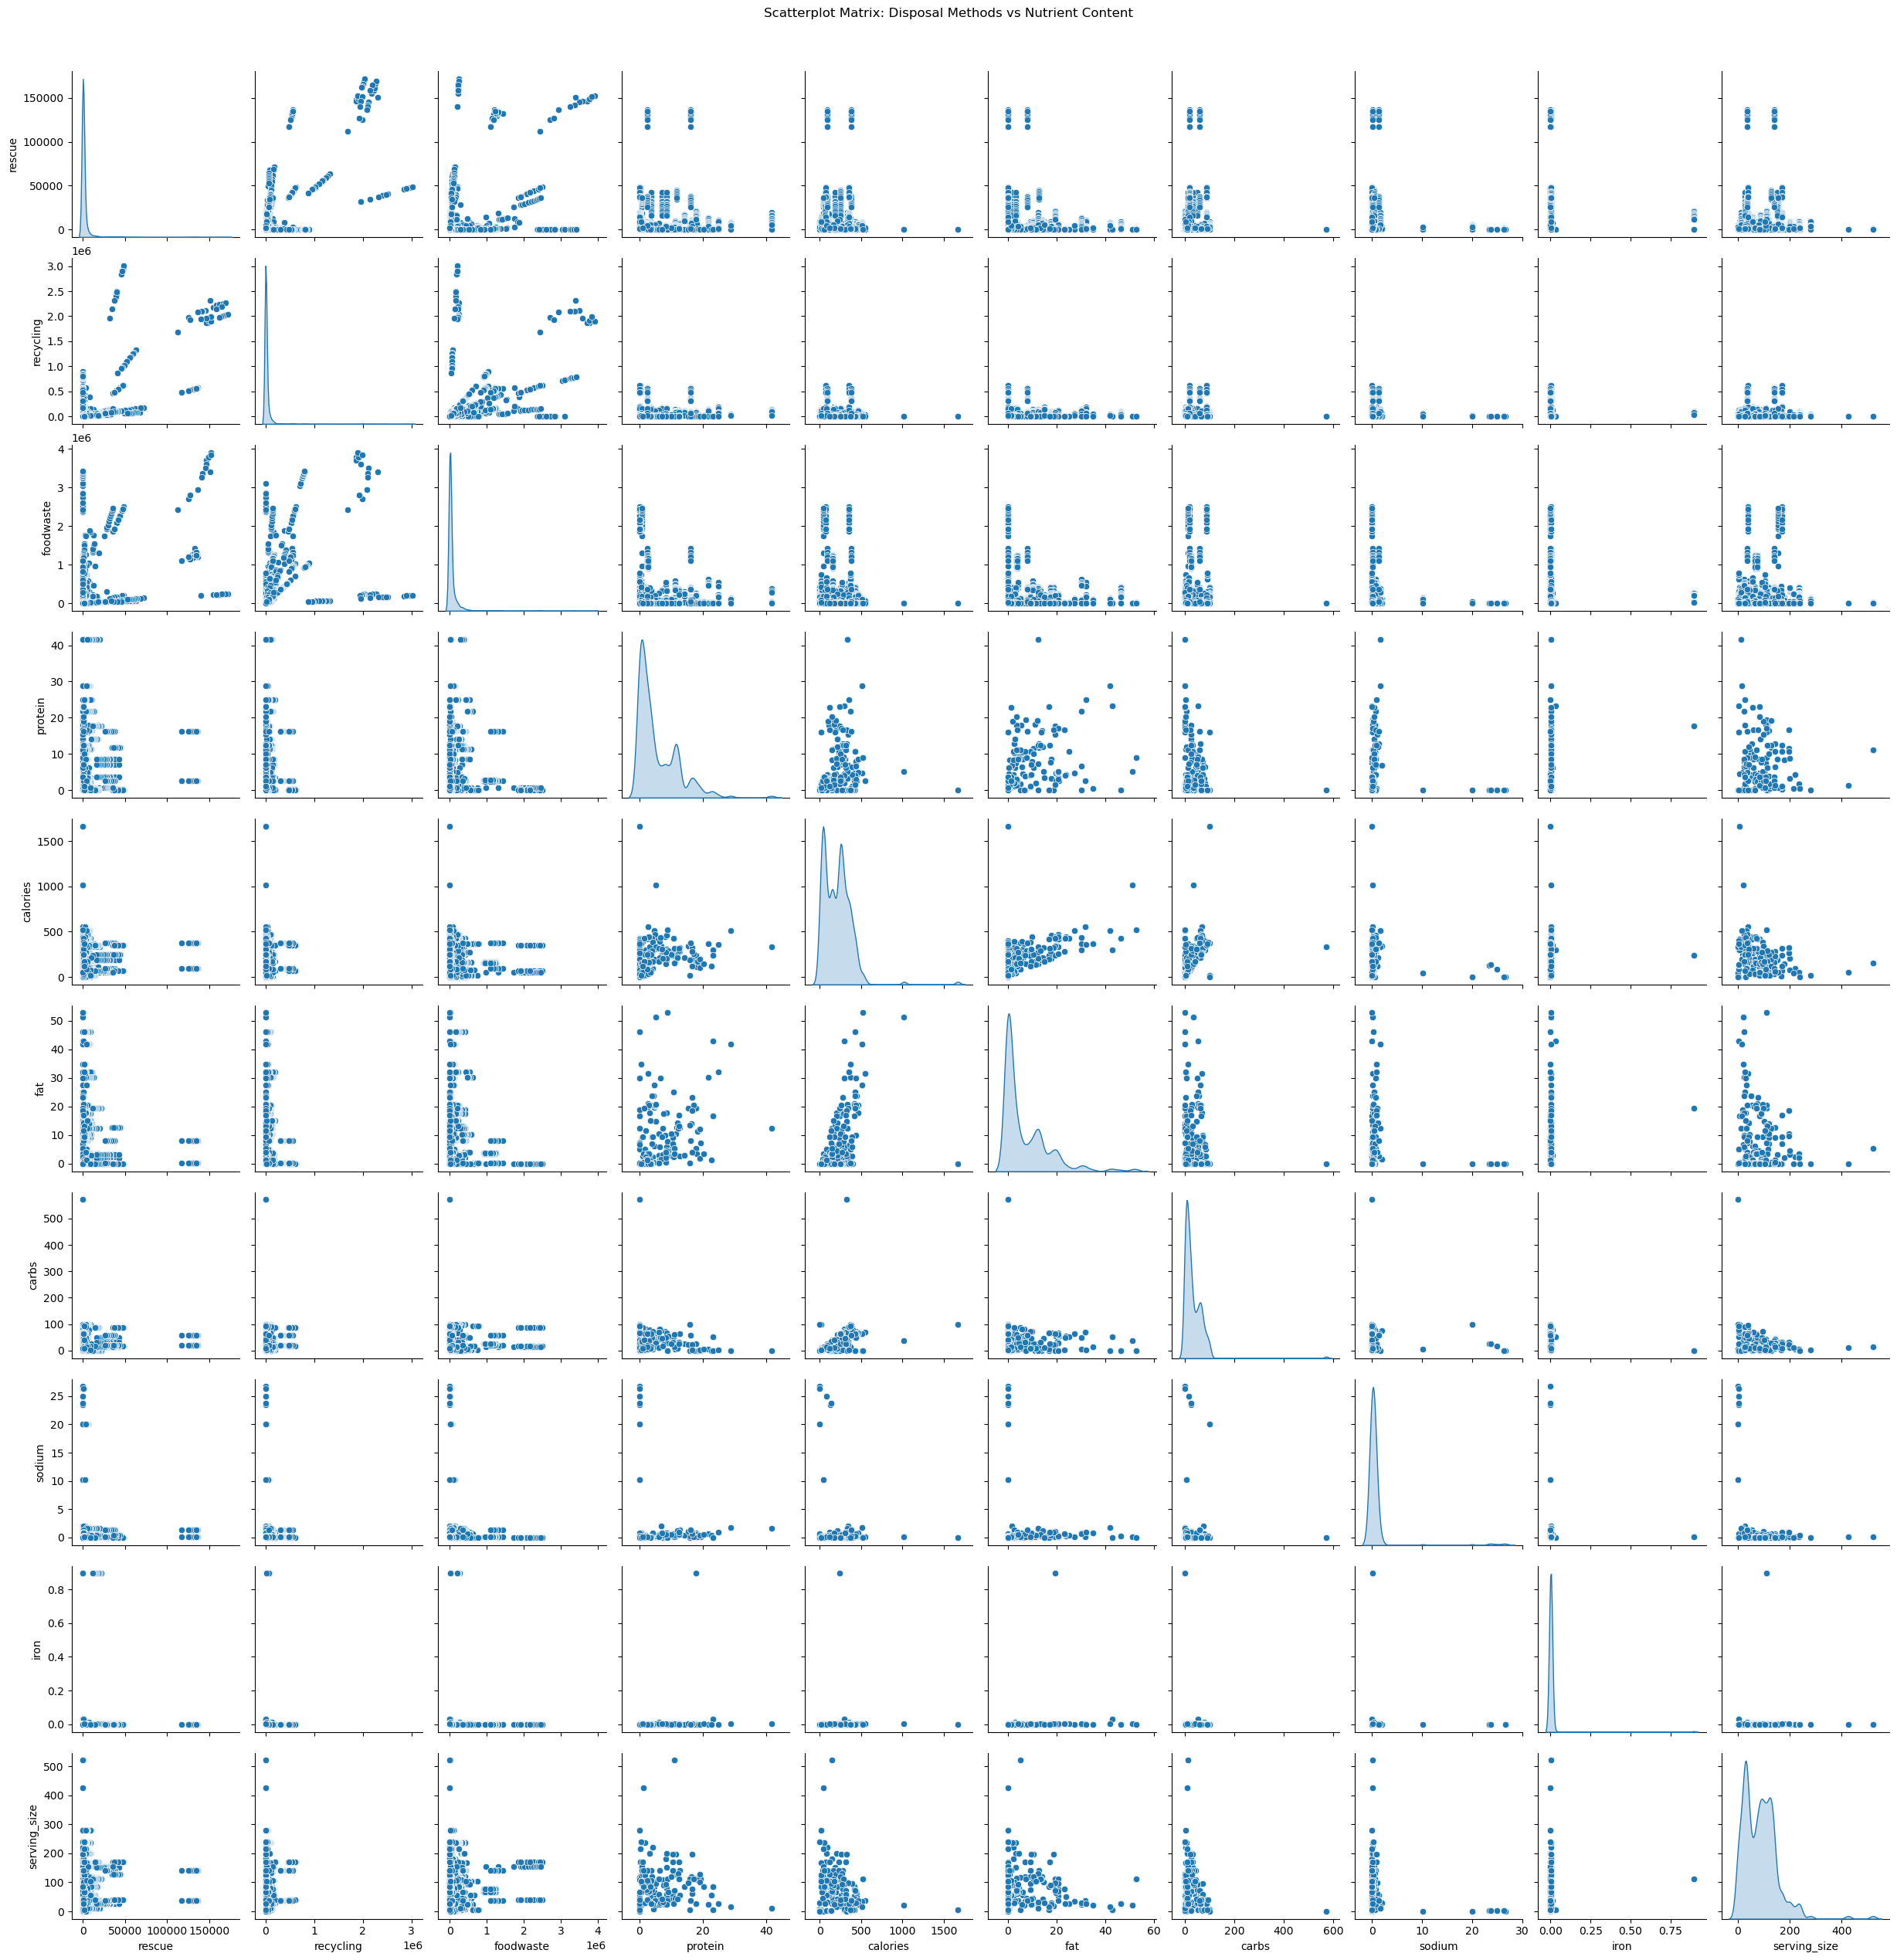

<module 'matplotlib.pyplot' from '/Users/shanaywadhwani/Desktop/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [73]:
disposal_cols = ['rescue', 'recycling', 'foodwaste'
    
]
nutrient_cols = ['protein', 'calories', 'fat', 'carbs', 'sodium', 'iron', 'serving_size']
eda.plot_scatter_matrix(disposal_cols, nutrient_cols)

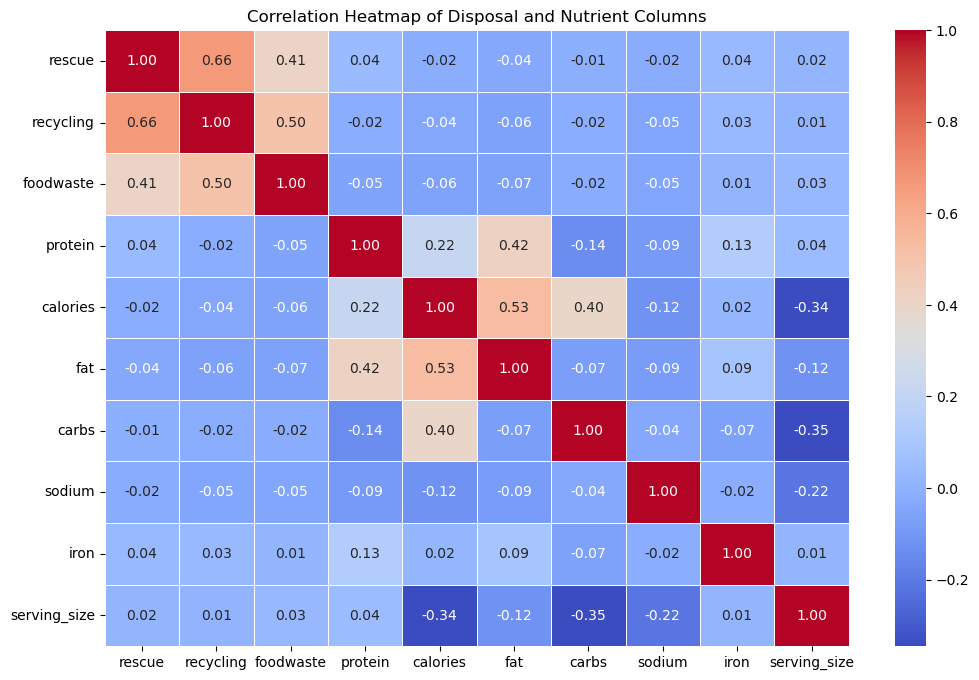

In [74]:
eda.plot_disposal_nutrient_correlation(disposal_cols, nutrient_cols)

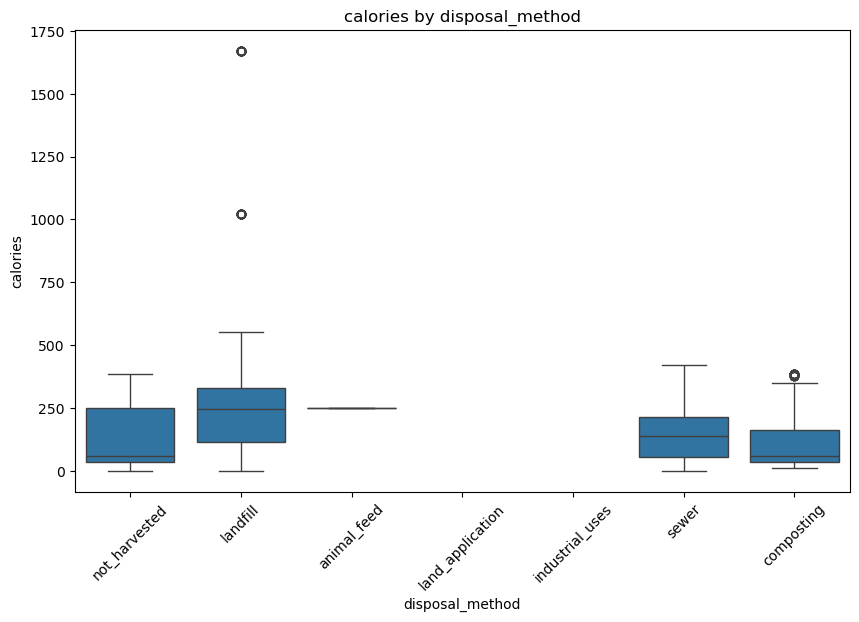

<module 'matplotlib.pyplot' from '/Users/shanaywadhwani/Desktop/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [75]:
eda.plot_nutrient_boxplot_by_disposal(disposal_col='disposal_method', nutrient_col='calories')

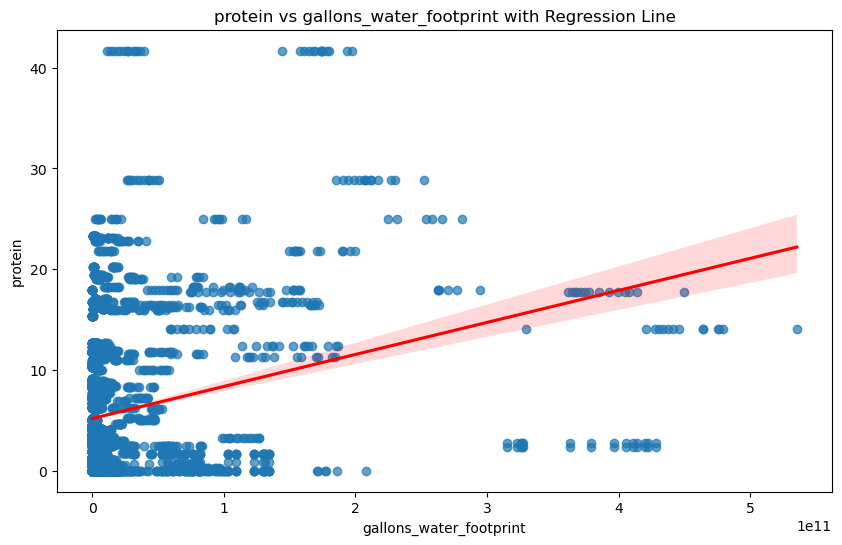

In [60]:
eda.plot_scatter_with_regression(disposal_col='gallons_water_footprint', nutrient_col='protein')

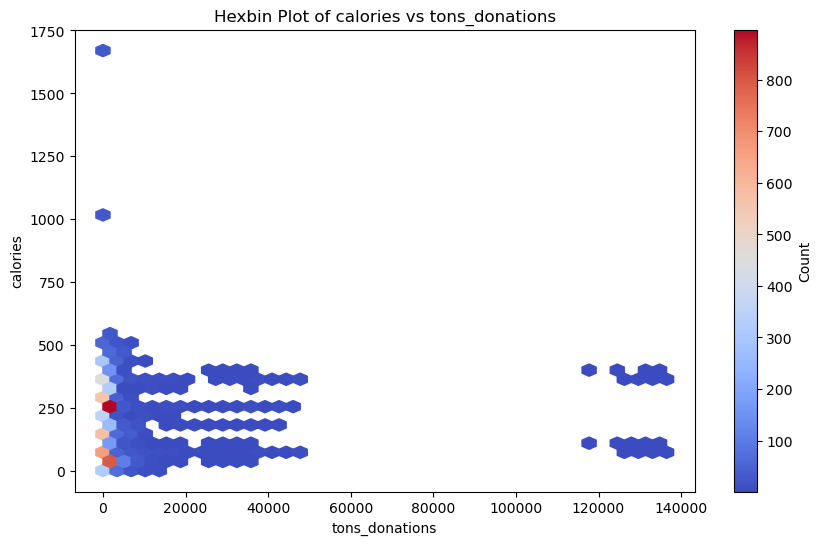

<module 'matplotlib.pyplot' from '/Users/shanaywadhwani/Desktop/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [77]:
eda.plot_hexbin(disposal_col='tons_donations', nutrient_col='calories', gridsize=40)

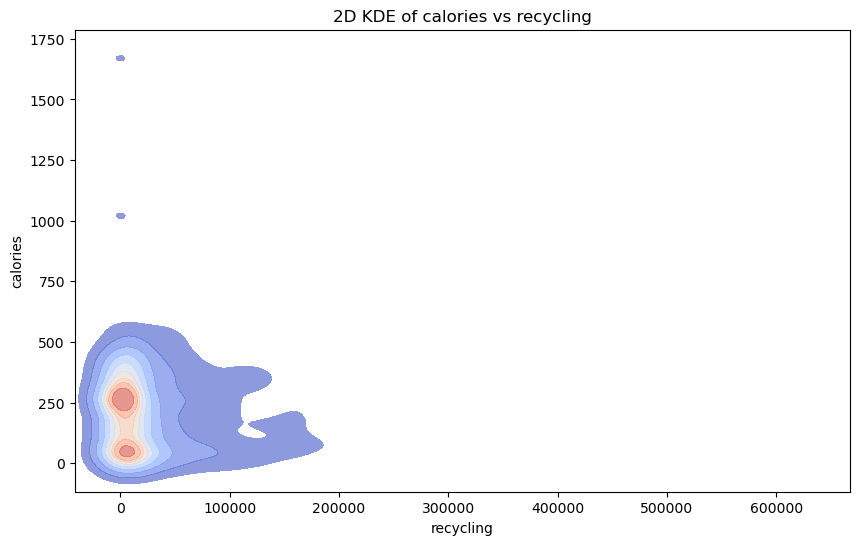

<module 'matplotlib.pyplot' from '/Users/shanaywadhwani/Desktop/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [78]:
eda.plot_kde_2d(disposal_col='recycling', nutrient_col='calories')

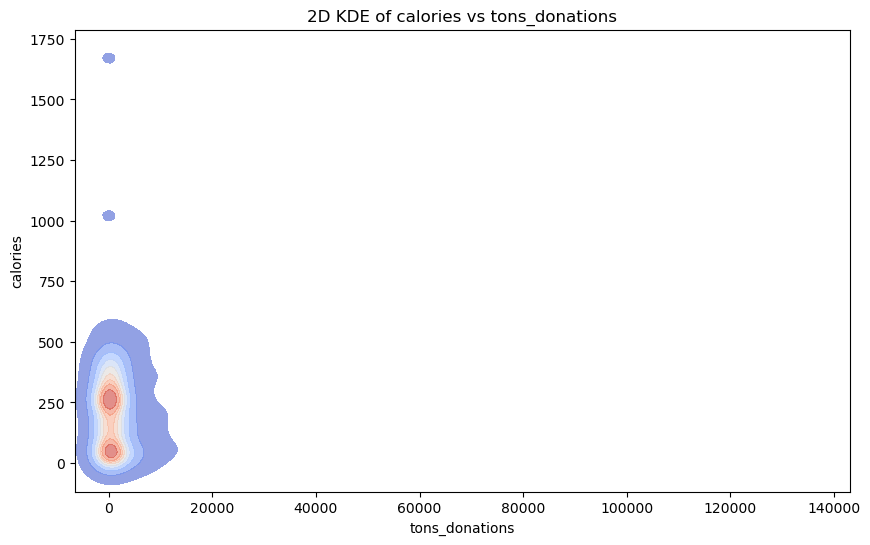

<module 'matplotlib.pyplot' from '/Users/shanaywadhwani/Desktop/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [79]:
eda.plot_kde_2d(disposal_col='tons_donations', nutrient_col='calories')

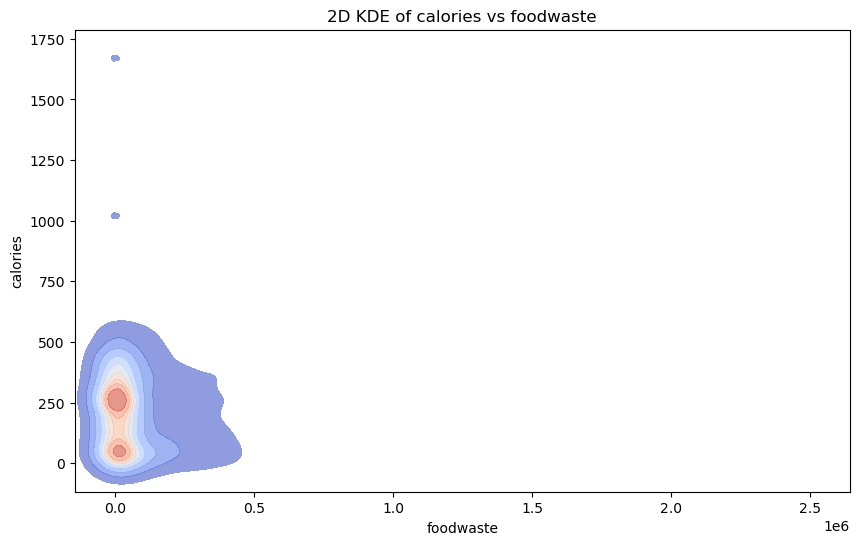

<module 'matplotlib.pyplot' from '/Users/shanaywadhwani/Desktop/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [80]:
eda.plot_kde_2d(disposal_col='foodwaste', nutrient_col='calories')

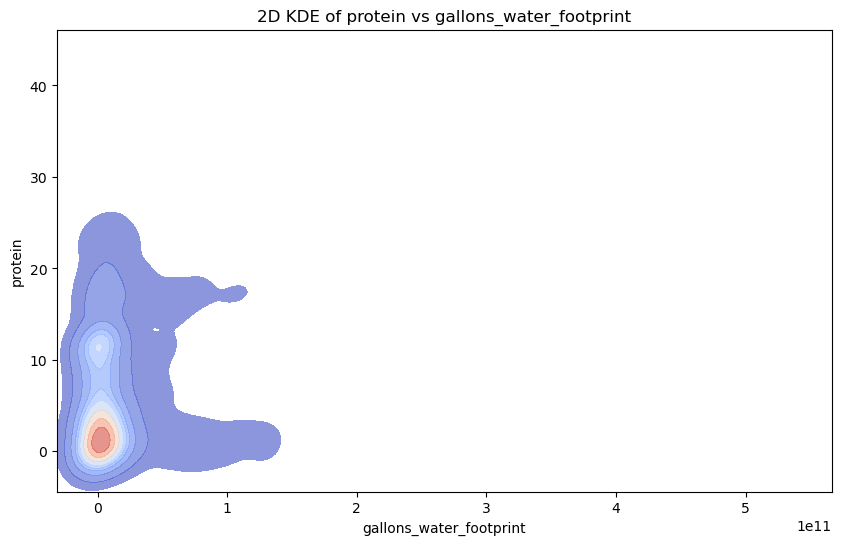

<module 'matplotlib.pyplot' from '/Users/shanaywadhwani/Desktop/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [81]:
eda.plot_kde_2d(disposal_col='gallons_water_footprint', nutrient_col='protein')

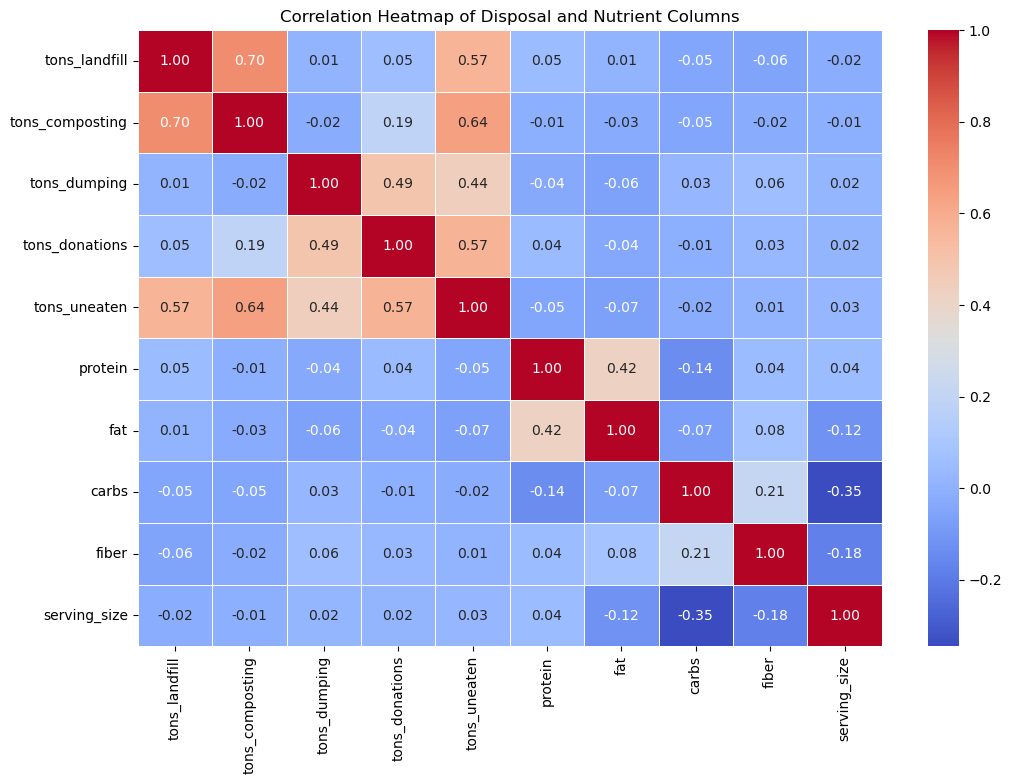

In [40]:
eda.plot_disposal_nutrient_correlation(
    disposal_cols=['tons_landfill', 'tons_composting', 'tons_dumping','tons_donations', 'tons_uneaten'],
    nutrient_cols=['protein', 'fat', 'carbs', 'fiber', 'serving_size']
)